# Shallow focus를 이용한 인물사진 만들기

### DeepLab segmentation model 적용

1.배경이 있는 셀카를 촬영 (배경과 사람의 거리가 약간 멀리 있는게 좋음)

2.시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리

3.블러링(blurring) 기술로 배경을 흐리게 함

4.피사체를 배경의 원래 위치에 합성

## 루브릭

- 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

- 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

- 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

## 용어 정리

- urllib는 웹에서 데이터를 다운로드할 때 사용합니다.
- cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요합니다.
- pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
- segmentAsPascalvoc :  PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미
- blur() : 배경을 흐리게하는 함수
- bitwise_not : 이미지가 반전(원본 마스크에서 배경이 0, 사람이 255였다면, 이 함수 사용시 배경이 255, 사람이 0 이됨)
- bitwise_and : 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있음. ( 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨, 즉 사람이 사라짐)
- numpy.where(condition, [x, y, ]/)

### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법

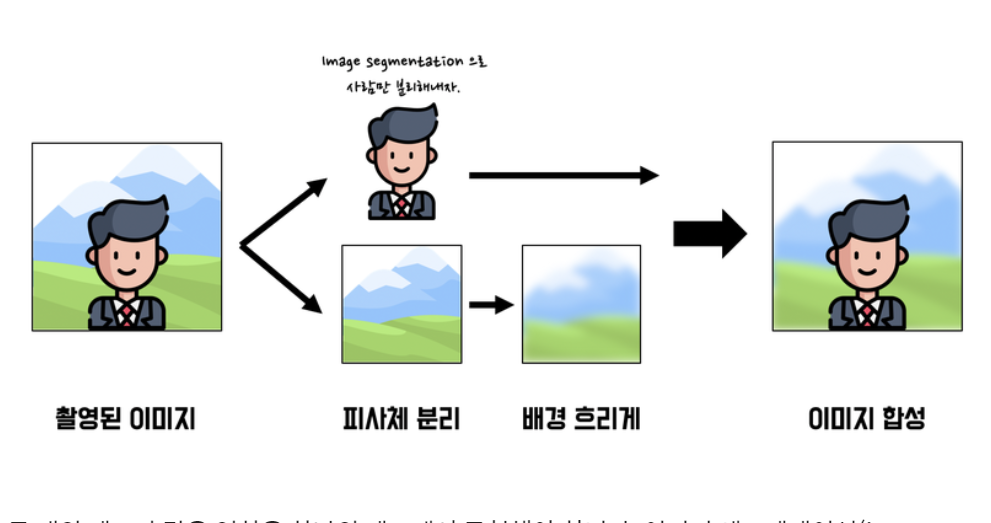

## 라이브러리 import

In [1]:
import os
from glob import glob
from os.path import join
import tarfile
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
import tensorflow as tf

## 이미지 준비하기

### 1. 인물사진

(1440, 1440, 3)


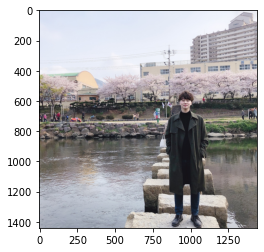

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/oh.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션으로 사람 분리하기

- Segmentation : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
- Semantic segmentation : 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류하고(classification)하는 방법으로서 개개별로 라벨링하는 것이 아닌 분류된 형태로서 라벨링 됨. ex) 영희와 숙희가 사람으로 라벨링 되는 것

- DeepLab V3+ : semantic segmentation 방법으로서,separable convolution과 atrous convolution을 결합한 atrous separable convolution의 활용을 제안하고 있음

- atrous convolution을 사용한 이유 : receptive field를 넓게 사용하기 위해 사용
 적은 파라미터로 필터가 더 넓은 영역을 보게 하기 위해
- Depthwise separable convolution : 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적

- Instance segmentation : 사람 개개인별로 다른 라벨을 가지게 함. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하게 도움 줌.

- Instance segmentation

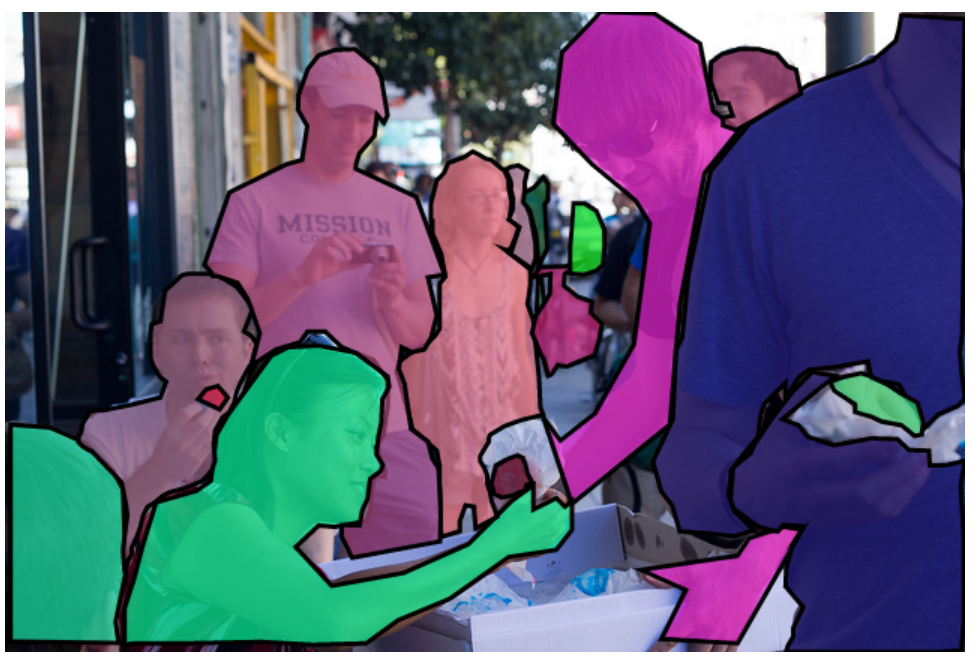

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc496ad2190>)

### 모델에 이미지 입력

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)
#PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

#background를 제외하면 20개의 클래스가 있음

21

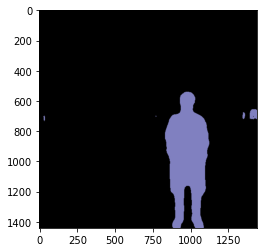

In [8]:
# person 라벨, 즉 15를 가진 영역만 검출해 내고 싶을 때
plt.imshow(output)
plt.show()

output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있음

In [9]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
# 색상 코드 결과물에 주목
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
# PixelLib에 따르면 위와 같은 색을 사용했다는 것을 확인함
colormap[15] # 사람으로 표시된 색상은 무엇인지 확인

# 이미지에서 사람외에 다른 물체를 찾고 싶을 때도 colormap[class_id] 처럼 사용. 

array([192, 128, 128])

 output 이미지가 BGR 순서로 채널 배치가 되어있는 반면, colormap은 RGB 순서임.
따라서, 추출해야 하는 색상 값은 순서를 바꿔줘야함

In [14]:
seg_color = (128,128,192)

(1440, 1440)


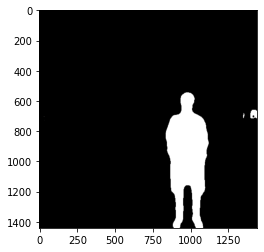

In [15]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됨.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

3채널 가졌던 원본과는 다르게 채널 정보가 사라졌음.
물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 됨.

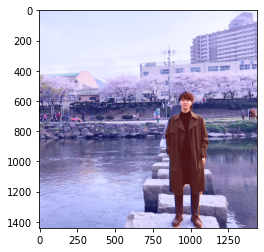

In [17]:
# 원본 이미지와 비교하여 세그멘티이션이 잘되었는지 확인
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봄
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봄
# 0.6과 0.4는 두 이미지를 섞는 비율임.
img_show = cv2.addWeighted(img_show, 1.0, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## blur()함수를 이용한 배경흐리게 하기

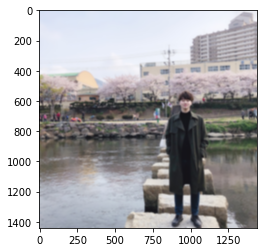

In [18]:
# (13,13)은 blurring kernel size를 뜻함.
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

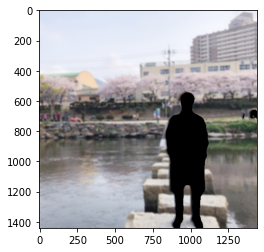

In [19]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# bitwise_not 함수를 이용하면 이미지가 반전됨.
# 전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있음.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨.

## 흐린 배경과 원본 영상 합성

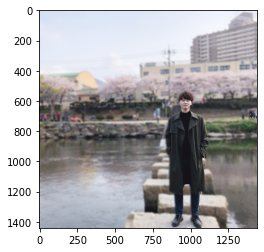

In [20]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용함.
np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했음.

### 문제점 :
- segmentation기법을 적용하였으나 원본 사진에 원거리에 있는 사람들이 부분적으로 라벨링 됨을 확인함

- 객체의 크기가 상대적으로 작으면 분할 성능이 저조해지는 문제점이 있어보임.
- 피사계심도를 이용한 아웃포커싱효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation)함.따라서 이를 모방한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기 어려움

### 2. 고양이사진

#### 이미지 준비하기

(298, 237, 3)


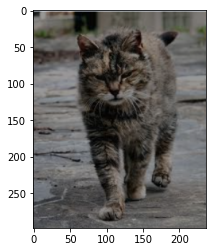

In [21]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path2)

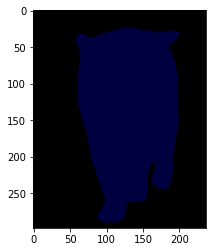

In [23]:
plt.imshow(output)
plt.show()

In [24]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [25]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [26]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [27]:
## 고양이를 나타내는 색상
colormap[8]

array([64,  0,  0])

In [28]:
seg_color = (0,0,64)

(298, 237)


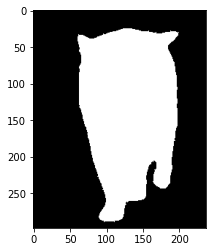

In [29]:
# seg_color로만 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됨
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

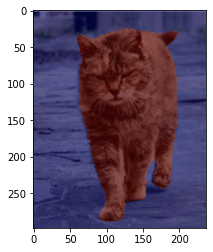

In [30]:
img_show = img_orig2.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 배경흐리게 하기

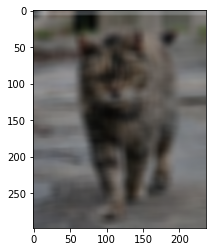

In [31]:
img_orig_blur = cv2.blur(img_orig2, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

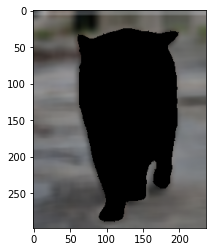

In [32]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

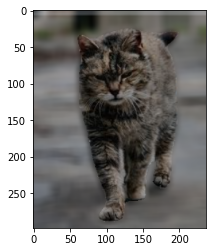

In [33]:
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 :

본 고양이 사진에서는 문제점 없이 잘 shallow foucs 되었다. 

그렇다면 고양이의 형체에서 다른 동물과 섞여 있는 사진은 어떻게 표현되는지 궁금해서 다른 그림을 시험해보았다

## 3. 고양이 사진

### 이미지 불러오기

(517, 745, 3)


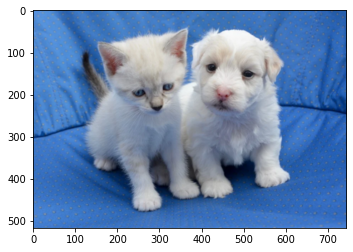

In [34]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.png'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)

plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [35]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path3)

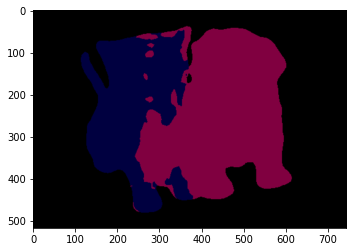

In [36]:
plt.imshow(output)
plt.show()

In [37]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
dog


In [38]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [39]:
colormap[12]

array([ 64,   0, 128])

In [40]:
seg_color = (128,0,64)

In [41]:
colormap[8]

array([64,  0,  0])

In [42]:
seg_color = (0,0,64)

(517, 745)


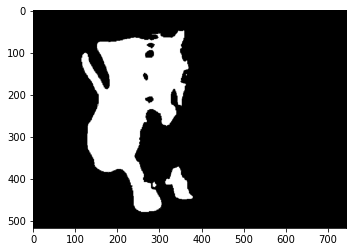

In [43]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

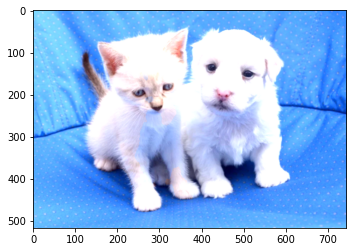

In [44]:
# 원본 이미지와 비교하여 세그멘티이션이 잘되었는지 확인
img_show = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봄
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봄
# 0.6과 0.4는 두 이미지를 섞는 비율임.
img_show = cv2.addWeighted(img_show, 1.5, color_mask, 0.2, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경흐리게 하기

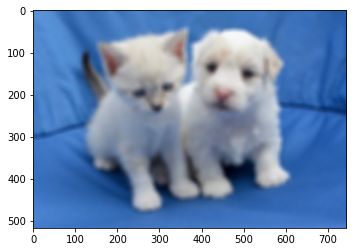

In [45]:
img_orig_blur = cv2.blur(img_orig3, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### Segmentation으로 배경만 추출하기

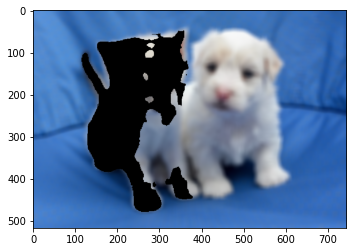

In [46]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경영상과 합치기

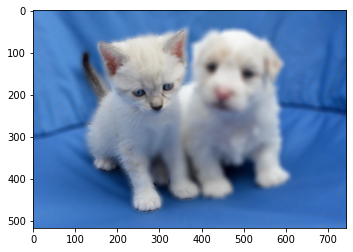

In [47]:
img_concat = np.where(img_mask_color==255, img_orig3, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 :
- 색깔이 비슷한 강아지와 고양이를 두었을 때 각 개체에 대해 구별은 하나 겹치는 부분 때문인지 완벽한 라벨링이 이루어지지 않아보임.
- 처음에, 세번째 사진에서 고양이가 새를 물고 있는 사진을 하였는데 새의 색깔이 분명해도 새의 모양이 가로로 누워있어서 그런지 인식을 하지못함.

### 해결방안
1) 객체를 뚜렷히 구분하지 못하는 부분에 있어서 cv2.addWeighted(img_show, 1.5, color_mask, 0.2, 0.0)에 대한 수치를 조정하였음
하지만, 완벽히 수행되지는 않음.

2) 객체의 크기가 일정 이하인 경우 인식하지 못하는 경우
-> ESRGAN을 통해 초해상화를 수행한 후, Semantic Soft Segmentation을 수행함으로써 소형 객체의 분할 성능을 개선이 필요할 것으로 사료됨.

## 참고
Deep Lab V3+ : https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

https://towardsdatascience.com/review-deeplabv3-atrous-convolution-semantic-segmentation-6d818bfd1d74